# Gemaps Data Analysis

6/27/19

Diagnostics for Parkinson's

Warning: drop the `name` column upon feature extraction, it's somewhere in the middle of the csv.  For simplicity I just found it in the excel and deleted it since it was an exact replica of the [0] label column.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json, sys, regex
from scipy import stats

# Motor Data

Original data from patients, taken by Huy. These are the Unified Parkinson Disease Rating Scale (UPDRS III motor score) results to which the feauture extraction data were compared. P value shows insignificant change between groups based off scipy library `ttest` function but hand calculation by Huy seemed to work.

Ttest_indResult(statistic=1.535735113080723, pvalue=0.16315374349509684)

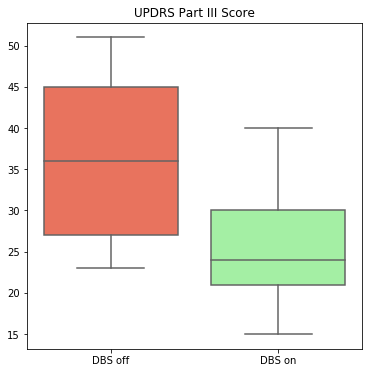

In [3]:
fig, axes = plt.subplots(figsize=(6,6)) # plot, enlarge


motor = pd.read_csv('Output_Folder/Motor/motor_use.csv')
my_pal = {"DBS off": "tomato", "DBS on": "palegreen"}
sns.boxplot(data=motor, order=["DBS off", "DBS on"], palette=my_pal).set_title('UPDRS Part III Score')

a = motor.iloc[:,0]
b = motor.iloc[:,1]
f = stats.ttest_ind(a,b)
    
f

Below are data for each of the five patients that were analyzed and assessed for motor scores by Huy. A clear reduction in patient motor school is observed when the DBS is turned on.  Huy preferred the above graph, but I wanted to visualize each patient's data separately for my own sanity.

Text(0.5, 1.0, 'UPDRS scores per patient')

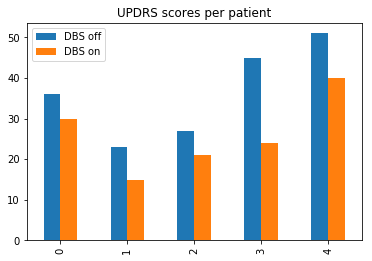

In [28]:
fig, ax = plt.subplots()
motor.plot.bar(ax=ax).set_title('UPDRS scores per patient') #stacked=True when Huy made his original data.

# Gemap Load

In [5]:
data = pd.read_csv('Output_Folder/Gemaps/Gemaps_features.csv')
names = list(data.columns)
data.head()

,Unnamed: 0,AudioFile,F0semitone27.5Hz_sma3nz_amean,F0semitone27.5Hz_sma3nz_meanFallingSlope,F0semitone27.5Hz_sma3nz_meanRisingSlope,F0semitone27.5Hz_sma3nz_pctlrange0-2,F0semitone27.5Hz_sma3nz_percentile20.0,F0semitone27.5Hz_sma3nz_percentile50.0,F0semitone27.5Hz_sma3nz_percentile80.0,F0semitone27.5Hz_sma3nz_stddevFallingSlope,...,slopeUV500-1500_sma3nz_amean,slopeV0-500_sma3nz_amean,slopeV0-500_sma3nz_stddevNorm,slopeV500-1500_sma3nz_amean,slopeV500-1500_sma3nz_stddevNorm,spectralFluxUV_sma3nz_amean,spectralFluxV_sma3nz_amean,spectralFluxV_sma3nz_stddevNorm,spectralFlux_sma3_amean,spectralFlux_sma3_stddevNorm
0,0,10_ahh_off.wav,26.1,5.86,7.1,0.459,25.9,26.1,26.3,3.77,...,0.00000,-0.00404,-3.62,-0.00596,-0.758,0.000,0.629,0.348,0.627,0.350
1,1,10_ahh_on.wav,25.0,1.82,51.2,0.194,25.1,25.2,25.3,0.00,...,-0.00292,-0.01340,-1.16,-0.00733,-1.260,0.129,0.356,0.370,0.352,0.378
2,2,10_animal_off.wav,20.2,107.00,240.0,12.700,13.7,22.0,26.4,155.00,...,-0.00678,-0.02820,-1.28,-0.01490,-0.927,0.212,0.478,0.885,0.373,1.010
3,3,10_animal_on.wav,19.2,100.00,195.0,12.000,13.5,16.2,25.5,140.00,...,-0.00581,-0.03220,-1.22,-0.01310,-0.900,0.179,0.371,0.915,0.292,0.986
4,4,10_counting_off.wav,26.6,81.20,800.0,2.590,25.9,27.2,28.5,90.70,...,-0.00485,0.00077,40.70,-0.01680,-0.779,0.481,0.634,0.534,0.592,0.579


# Split Exp and Ctrl

Split into DBS_on experimental and DBS_off control.  Allows chisq testing and pipeline implementation.  Also was conducive to our simpler t-test analysis later.

In [8]:
#split by pd index
off_data = data[::2]
on_data = data[1::2]

#generate json files for the select_features.py file
off_data = off_data.drop(['AudioFile', 'Unnamed: 0'], 1)
on_data = on_data.drop(['AudioFile', 'Unnamed: 0'], 1) 

# Prep Chi Sq

This is just straight from the pipeline provided in the voicebook with a few tweaks.  This was not necessary to produce for the data presented at the symposium, but is provided here as a reference for the modified code that works in notebook form.

In [9]:
X=np.array(on_data)
Y=np.array(off_data)
training=list()
for i in range(len(X)):
    training.append(X[i])
for i in range(len(Y)):
    training.append(Y[i])

# get labels (as binary class outputs)
labels=list()
for i in range(len(X)):
    labels.append(1)
for i in range(len(Y)):
    labels.append(0) 

# Chi Sq from VoiceBook

Straight from `select_features.py` from the Voicebook.  Also unnecessary for the symposium data, and is just provided as a commented/tweaked reference guide for future study.

In [10]:
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(training, labels, test_size=0.20, random_state=42)
X_train=np.array(X_train)
X_test=np.array(X_test)
y_train=np.array(y_train).astype(int)
y_test=np.array(y_test).astype(int)

# normalize features so they are non-negative [0,1], or chi squared test will fail
# it assumes all values are positive 
min_max_scaler = preprocessing.MinMaxScaler()
chi_train = min_max_scaler.fit_transform(X_train)
chi_labels = y_train 

# Select 50 features with highest chi-squared statistics
chi2_selector = SelectKBest(chi2, k=50)
X_kbest = chi2_selector.fit_transform(chi_train, chi_labels)

# Recursive Feature Elimination, Voicebook

Recursive feature elmination works by recursively removing 
attributes and building a model on attributes that remain. 
It uses model accuracy to identify which attributes
(and combinations of attributes) contribute the most to predicting the
target attribute. You can learn more about the RFE class in
the scikit-learn documentation.  This finds the top 25 features according 
to the Gemaps algorithm.

May be desirable to surpress warning for running in Jupyter.

Recursive feature elmination was supposed to identity features that might work well with the properties of the data set.  However, scanning the p values from the t-test results showed that most of the features were meaningless at the scale of our sample size.

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

import warnings
warnings.filterwarnings("ignore")

# Top 25 features
model = LogisticRegression() 
rfe = RFE(model, 25)
fit = rfe.fit(X_train, y_train)

# list out number of features and selected features 
print("Num Features: %d"% fit.n_features_) 
print("Selected Features: %s"% fit.support_) 
print("Feature Ranking: %s"% fit.ranking_)

Num Features: 25
Selected Features: [ True  True False False False  True  True  True False False  True False
 False False False False False  True False False False False  True False
 False False False False False  True False  True False False False False
  True  True  True False  True False False False False False  True  True
 False False  True False False False False False False False False False
 False False  True False  True False  True  True  True False False  True
  True False False False False False False False  True False False False
 False False False False]
Feature Ranking: [ 1  1 41 23 51  1  1  1 56 26  1 32  7 61  4 54 11  1 13 52  8 57  1 37
 49 50 17 63 25  1 48  1 18 46 36 19  1  1  1 33  1 21 58 34  2 22  1  1
 20 38  1  9 28 29 35 47 12 27  6  5 45  3  1 10  1 39  1  1  1 24 15  1
  1 14 16 31 44 53 59 55  1 62 40 42 64 43 60 30]


The following scripts are designed to display all of the features and their associated t stat and p-values.

In [29]:
fit.support_.size
indx = np.where(fit.support_==True)
indx = np.array(indx)
# indx.flatten()

# apparently a bug in np req np.frombuffer to get 1D array. otherwise the for loop below doesn't work.
indx = np.frombuffer(indx,dtype=int)
indx = indx[::2]

In [30]:
features = [names[i+1] for i in indx]
#features  #supposedly selected features

In [33]:
# easier naming for downstream analysis
names = [s.replace('_sma3nz_', ' ') for s in names]
names = [s.replace('stddev', 'std ') for s in names]


# generate t stat results
t_results = dict()
p_vals = list()
t_vals = list()
for i in range(0,88):
    a = off_data.iloc[:,i]
    b = on_data.iloc[:,i]
    f = stats.ttest_ind(a,b,equal_var=True)
    p_vals.append(f.pvalue)
    t_vals.append(f.statistic)
    t_results[names[i+2]] = f
t_results

{'F0semitone27.5Hz amean': Ttest_indResult(statistic=0.3281530830678242, pvalue=0.7442231323611543),
 'F0semitone27.5Hz meanFallingSlope': Ttest_indResult(statistic=-0.36538509762723953, pvalue=0.7164291890853429),
 'F0semitone27.5Hz meanRisingSlope': Ttest_indResult(statistic=2.0848785046711233, pvalue=0.04242338194063342),
 'F0semitone27.5Hz pctlrange0-2': Ttest_indResult(statistic=0.1612431397377509, pvalue=0.8725786723791664),
 'F0semitone27.5Hz percentile20.0': Ttest_indResult(statistic=0.6123336279222946, pvalue=0.5432071117966031),
 'F0semitone27.5Hz percentile50.0': Ttest_indResult(statistic=-0.045891042398669445, pvalue=0.9635874906327186),
 'F0semitone27.5Hz percentile80.0': Ttest_indResult(statistic=0.6555735818832908, pvalue=0.5152285335795546),
 'F0semitone27.5Hz std FallingSlope': Ttest_indResult(statistic=-1.2182668065966749, pvalue=0.2290769429017865),
 'F0semitone27.5Hz std Norm': Ttest_indResult(statistic=0.2062626294776831, pvalue=0.8374581755975045),
 'F0semitone27.

Two features were identified as showing a statistically significant relationship between patient data in the DBS off and on state. These features merit further exploration.  One particularly noteworthy finding is that the best features are associated with the mean rising slope of the vocal features in the samples; I would think of this as a first derivative, a measure that does not really depend on the frequency (pitch) regime of the patient's voice. This is great because each patient had a incredibly different tonal quality: some voices were deep while others were high pitched.  The rising slope, however, seems to be more an indication that the voice is suddenly changing in pitch, and thus the measure can be more broadly used across a range of natural vocal frequency ranges.  Again, to test this hypothesis, a more stringent analysis of the frequency dependent (non-derivative features) might be needed, as to assess whether, indeed, those features have high p values.

In [17]:
df10 = data.iloc[:,11] # t = 2.40, p = .04
df03 = data.iloc[:,4]  # t = 2.08 p = .02

sig_features = pd.concat([df03,  df10], axis = 1, sort=False)
sig_features.head()

,F0semitone27.5Hz_sma3nz_meanRisingSlope,F0semitone27.5Hz_sma3nz_stddevRisingSlope
0,7.1,4.92
1,51.2,36.10
2,240.0,414.00
3,195.0,222.00
4,800.0,814.00


# Plotting only 3, 10

We combine important features and merge on and off columns into one dataframe to ease seaborn histogram plotting. Data is shown as a histogram with associated p values.

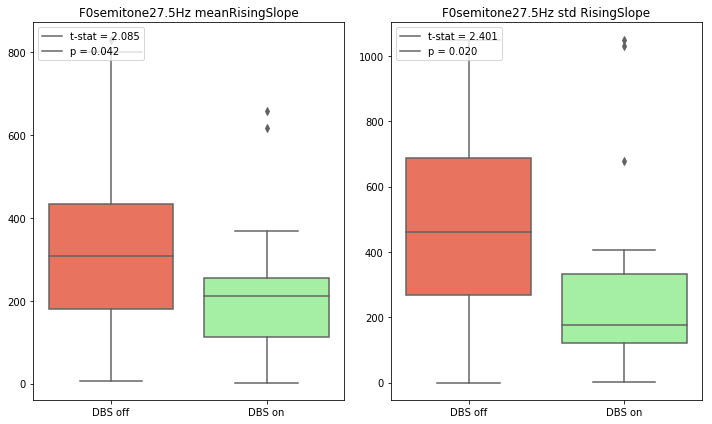

In [18]:
fig, axes = plt.subplots(figsize=(10,6)) # plot, enlargen

k = 1
for i in [4, 11]:
    
    df = data.iloc[:,i]  # separate on off data
    off = df[::2]
    on = df[1::2]

    # reset index for merge with non NaN values:
    off.reset_index(drop=True, inplace=True)
    on.reset_index(drop=True, inplace=True)

    full = pd.concat([off, on], axis=1)   # concatenate to one 24x2 df
    full.columns.values[[0, 1]] = ['DBS off', 'DBS on']  # rename dataframe columns, for plotting
    
    # Plot 1x2
    plt.subplot(1, 2, k)
    df_title = names[i]
    my_pal = {"DBS off": "tomato", "DBS on": "palegreen"}
    sns.boxplot(data=full, order=["DBS off", "DBS on"], palette=my_pal).set_title(df_title)
    
    # Print Legend
    p_legend = 'p = ' + str('%.3f'%p_vals[i-2]) 
    t_legend = 't-stat = ' + str('%.3f'%t_vals[i-2])
    k += 1
    plt.legend(loc='upper left', labels=[t_legend, p_legend])
    
fig.tight_layout(h_pad=1)
plt.show()

To put the above graphs into some better context, we show results derived from the first 12 features extracted by the Gemaps library. T stat and p values associated with each are shown in the top left.

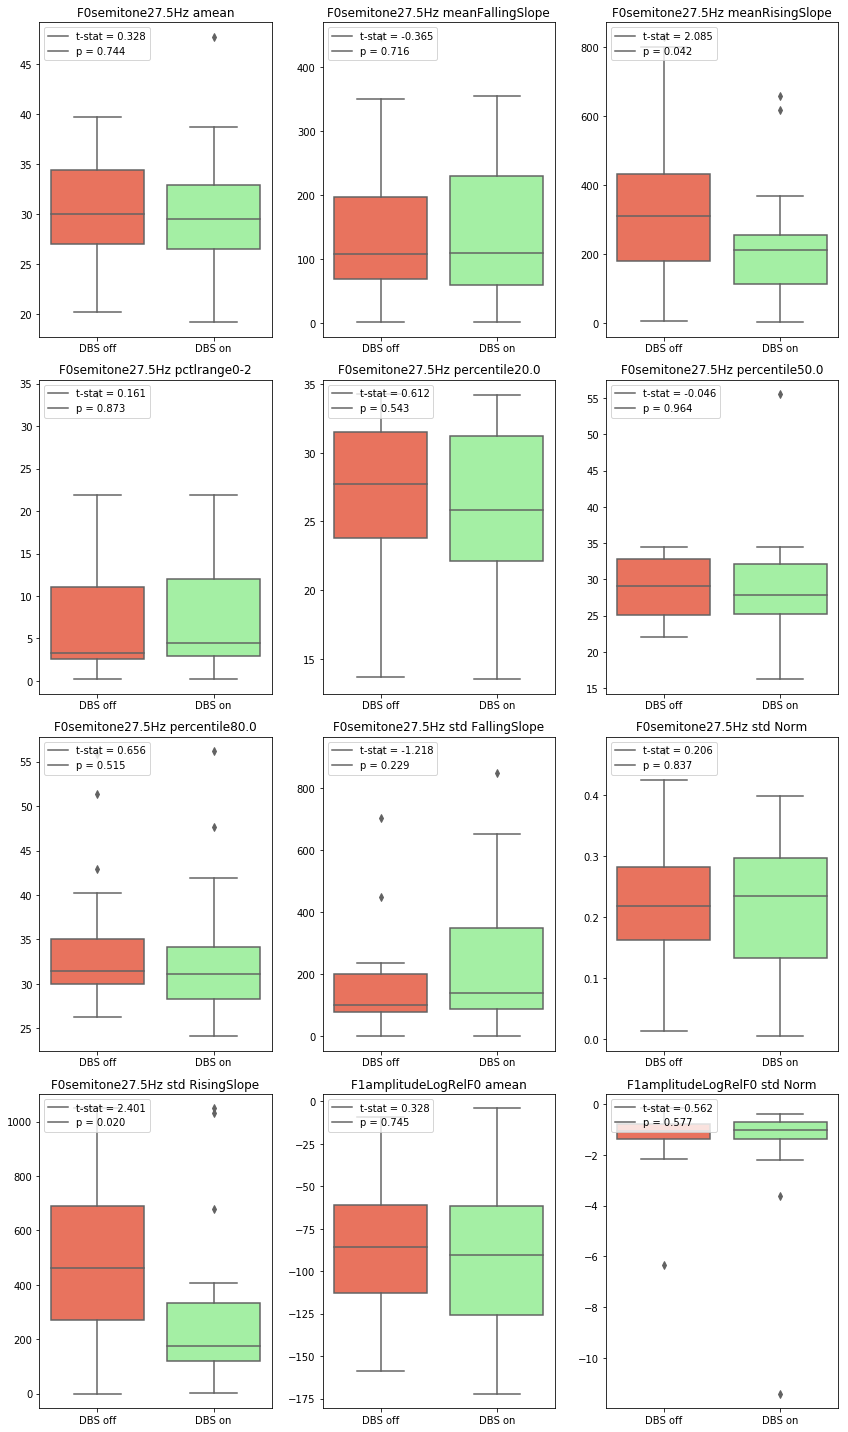

In [19]:
fig, axes = plt.subplots(figsize=(12,20)) # plot, enlargen

for i in range(2,14):
    
    df = data.iloc[:,i]  # separate on off data
    off = df[::2]
    on = df[1::2]
    
    # reset index for merge with non NaN values:
    off.reset_index(drop=True, inplace=True)
    on.reset_index(drop=True, inplace=True)

    full = pd.concat([off, on], axis=1)   # concatenate to one 24x2 df
    full.columns.values[[0, 1]] = ['DBS off', 'DBS on']  # rename dataframe columns, for plotting
    
    plt.subplot(4, 3, i-1)
    df_title = names[i]
    my_pal = {"DBS off": "tomato", "DBS on": "palegreen"}
    sns.boxplot(data=full, order=["DBS off", "DBS on"], palette=my_pal).set_title(df_title)
 
    
    p_legend = 'p = ' + str('%.3f'%p_vals[i-2]) 
    t_legend = 't-stat = ' + str('%.3f'%t_vals[i-2])
    
    plt.legend(loc='upper left', labels=[t_legend, p_legend])
fig.tight_layout(h_pad=1)
plt.show()

# Wilcoxon Comparison Test

The Wilcoxon is the non-parametric equivalent to the t-test performed above. It does not assume some normal distribution and thus we felt that its application would be beneficial here because of the small sample size and high frequency regime variability of the individuals who were recorded.  The Wilconxon returns p values that are slightly more promising than the t-test above and are consistent with the results yielded above as well. Should use with caution, because we don't really know if a higher sample size would actually allow some more of the parametric t-test results in for the features to converge anyway.

In [24]:
# defn dict to pair name with each stat and pval result
wilcoxon_results = dict()
p_vals = list()
w_vals = list()
for i in range(0,88):
    a = off_data.iloc[:,i]
    b = on_data.iloc[:,i]
    f = stats.wilcoxon(a,b)  # comparison
    p_vals.append(f.pvalue)  
    w_vals.append(f.statistic)
    wilcoxon_results[names[i+2]] = f
wilcoxon_results

{'F0semitone27.5Hz amean': WilcoxonResult(statistic=95.0, pvalue=0.11606452299293717),
 'F0semitone27.5Hz meanFallingSlope': WilcoxonResult(statistic=116.0, pvalue=0.3313349065031326),
 'F0semitone27.5Hz meanRisingSlope': WilcoxonResult(statistic=33.0, pvalue=0.002401067283616069),
 'F0semitone27.5Hz pctlrange0-2': WilcoxonResult(statistic=132.0, pvalue=0.6070522480710051),
 'F0semitone27.5Hz percentile20.0': WilcoxonResult(statistic=90.0, pvalue=0.14419666007323179),
 'F0semitone27.5Hz percentile50.0': WilcoxonResult(statistic=89.0, pvalue=0.08131196278606516),
 'F0semitone27.5Hz percentile80.0': WilcoxonResult(statistic=101.0, pvalue=0.26038423875642036),
 'F0semitone27.5Hz std FallingSlope': WilcoxonResult(statistic=88.0, pvalue=0.0764744430757926),
 'F0semitone27.5Hz std Norm': WilcoxonResult(statistic=133.0, pvalue=0.6271697535393987),
 'F0semitone27.5Hz std RisingSlope': WilcoxonResult(statistic=68.0, pvalue=0.019136708854110035),
 'F1amplitudeLogRelF0 amean': WilcoxonResult(stat